In [1]:
import os
import json
import glob
import shutil
from math import dist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties

In [2]:
class localization_error():
    def __init__(self, src):
        self.src = src
        self.ear_types = ["free","attached"]
        self.degrees = ['15cm_0mm_0deg', '15cm_25mm_5deg', '15cm_50mm_10deg',
                        '20cm_0mm_0deg', '20cm_25mm_5deg', '20cm_50mm_10deg']
        self.acupoints_name = ["HX6(肛門)", "HX3(尿道)", "HX1(耳中)", "TF4(神門)", "AH9(腰柢椎)", "AH11(胸椎)", "CO5(十二指腸)", 
                               "CO4(胃)", "CO3(賁門)", "CO14(肺)", "CO15(心)", "CO18(內分泌)", "HX2(輪2)", "AT2(緣中)", 
                               "LO8(扁桃體)", "LO1(牙)" , "LO2(舌)", "LO3(頷)", "LO4(垂前)", "LO5(眼)", "LO6(內耳)"]
        self.cm = {"cather":4.72, "daniel":4.74, "dominic":3.9, "jack":3.91, "jakaria":4.20, "jimmy":4.60, "vicky":4.69, "wayne":4.75,
                   "gaby":4.05, "matt":5.0, "toby":4.26, "wendy":4.14, "willy":4.51}
    
    def read_csv(self, fpath1):
        df = pd.read_csv(fpath1, index_col = 0)
        return df
                    
    def convert_to_error_csv(self):
        for ear_type in self.ear_types:
            names = os.listdir(os.path.join("..", self.src, ear_type, "result"))
            for name in names:
                for deg in self.degrees:
                    gt = os.path.join("..", "ground_truth", ear_type, "result", name , deg, "gt.csv")
                    pred = os.path.join("..", self.src, ear_type, "result", name, "pred", deg, "pred.csv")

                    gt_df = self.read_csv(gt)
                    pred_df = self.read_csv(pred)

                    error_df = pd.DataFrame(columns=gt_df.columns, index = gt_df.index)

                    assert len(gt_df) == len(pred_df), "different frames"
                    for i in range(0, len(gt_df)):
                        
                        scale0_x = float(gt_df.iloc[i,0].split(",")[0])
                        scale0_y = float(gt_df.iloc[i,0].split(",")[1])

                        scale11_x = float(gt_df.iloc[i,11].split(",")[0])
                        scale11_y = float(gt_df.iloc[i,11].split(",")[1])

                        scale = self.cm[name] / dist((scale0_x, scale0_y), (scale11_x, scale11_y))

                        for j in range(0, len(gt_df.columns)):
                            if gt_df.iloc[i,j].split(",")[2] == "2":
                                pred_x = float(pred_df.iloc[i,j].split(",")[0])
                                pred_y = float(pred_df.iloc[i,j].split(",")[1])

                                gt_x = float(gt_df.iloc[i,j].split(",")[0])
                                gt_y = float(gt_df.iloc[i,j].split(",")[1])

                                error_df.iloc[i,j] = scale * dist((gt_x, gt_y), (pred_x, pred_y))



                    error_path = os.path.join("..", self.src, ear_type, "result", name, "error",deg)
                    if not os.path.isdir(error_path):
                        os.makedirs(error_path)
                    error_df.to_csv(os.path.join(error_path, "error.csv"))

In [9]:
class localization_error_Draw():
    def __init__(self, le_0):
        self.le_0 = le_0
    def read_csv_to_np(self, fpath1):
        df_np = pd.read_csv(fpath1, index_col = 0).to_numpy()
        return df_np
    def all_err(self):
        result = {}
        for ear_type in self.le_0.ear_types:
            result[ear_type] = []
            names = os.listdir(os.path.join("..", self.le_0.src, ear_type, "result"))
            for name in names:
                deg_err = []
                for deg in self.le_0.degrees:
                    angles_err = []
                    error_np = self.read_csv_to_np(os.path.join("..", self.le_0.src, ear_type, "result", name, "error", deg, "error.csv"))
                    interval = len(error_np) / 3
                    index = [0, int(interval), int(interval*2), len(error_np)-1]
                    for i in index:
                        angles_err.append(error_np[i])

                    deg_err.append(angles_err)

                result[ear_type].append(deg_err)             #shape = (subjects, degrees, angles, acupoints)           
            result[ear_type] = np.array(result[ear_type])
#             print(np.nanmean(result[ear_type], axis = (2,3)))
            
            
        return result
    
    def draw_each_acu_bars(self, title, all_err_0):
        for ear_type in self.le_0.ear_types:
            x = np.transpose(all_err_0[ear_type]*10, (1, 2, 3, 0))
            means = np.nanmean(x, axis = 3)
            stds = np.nanstd(x, axis = 3)
            for i in range(0, len(x)):
                plt.figure(figsize=(15,10))
                for j in range(0 ,len(x[0])):
                    
                    plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)


                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(x.shape[2]) + 0.3, self.le_0.acupoints_name[:x.shape[2]], fontsize=12, rotation=-45, ha='center')


                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17, ncol = 2)

                plt.tight_layout()

#                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))
                
                plt.show()

    
        
        
        
    def draw_each_subject_bars(self, title, all_err_0):
        for ear_type in self.le_0.ear_types:
            x = np.transpose(all_err_0[ear_type]*10, (1, 2, 0, 3))
            means = np.nanmean(x, axis = 3)
            stds = np.nanstd(x, axis = 3)
            for i in range(0, len(x)):
                plt.figure(figsize=(15,10))
                for j in range(0 ,len(x[0])):
                    
                    plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)


                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(x.shape[2]) + 0.3, ["Subject"+str(x) for x in list(range(0 , x.shape[2]))], fontsize=12, rotation=-45, ha='center')


                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17, ncol = 2)

                plt.tight_layout()

#                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))
                
                plt.show()
        
    def draw_total_bars(self, title, all_errs, different_methods):
        plt.figure(figsize=(15,10))
        for i in range(0, len(all_errs)):
            means = []
            stds = []
            for ear_type in self.le_0.ear_types:
                means.append(np.nanmean(all_errs[i][ear_type], axis = (0,1,2,3))*10)
                stds.append(np.nanstd(all_errs[i][ear_type], axis = (0,1,2,3))*10)

                print(ear_type,means)

            plt.bar(np.arange(len(self.le_0.ear_types)) + i*0.2, means, yerr=stds, align='center', label = different_methods[i], ecolor='black', capsize=3, width=0.2)

        plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

        font_path = r'C:\Windows\Fonts\msjhl.ttc'
        font = FontProperties(fname=font_path, size=12)
        plt.xticks(np.arange(len(self.le_0.ear_types)) + 0.1, self.le_0.ear_types, fontsize=12, rotation=-45, ha='center')


        plt.yticks(fontsize=30)
        plt.title(title, fontsize = 30, pad = 20)

        plt.legend(fontsize=17, ncol = 2)

        plt.tight_layout()

        if not os.path.isdir(os.path.join("..", "figure", "diff_inpainting_way")):
            os.makedirs(os.path.join("..", "figure", "diff_inpainting_way"))
        plt.savefig(os.path.join("..", "figure", "diff_inpainting_way",'total_average.png').format(index = 0))

        plt.show()



In [10]:
A = localization_error("MAT_inpainting")
B = localization_error("traditional_inpainting")

free [1.3384753302649313]
attached [1.3384753302649313, 1.3916733461266344]
free [1.3231219957574536]
attached [1.3231219957574536, 1.3360809363077268]


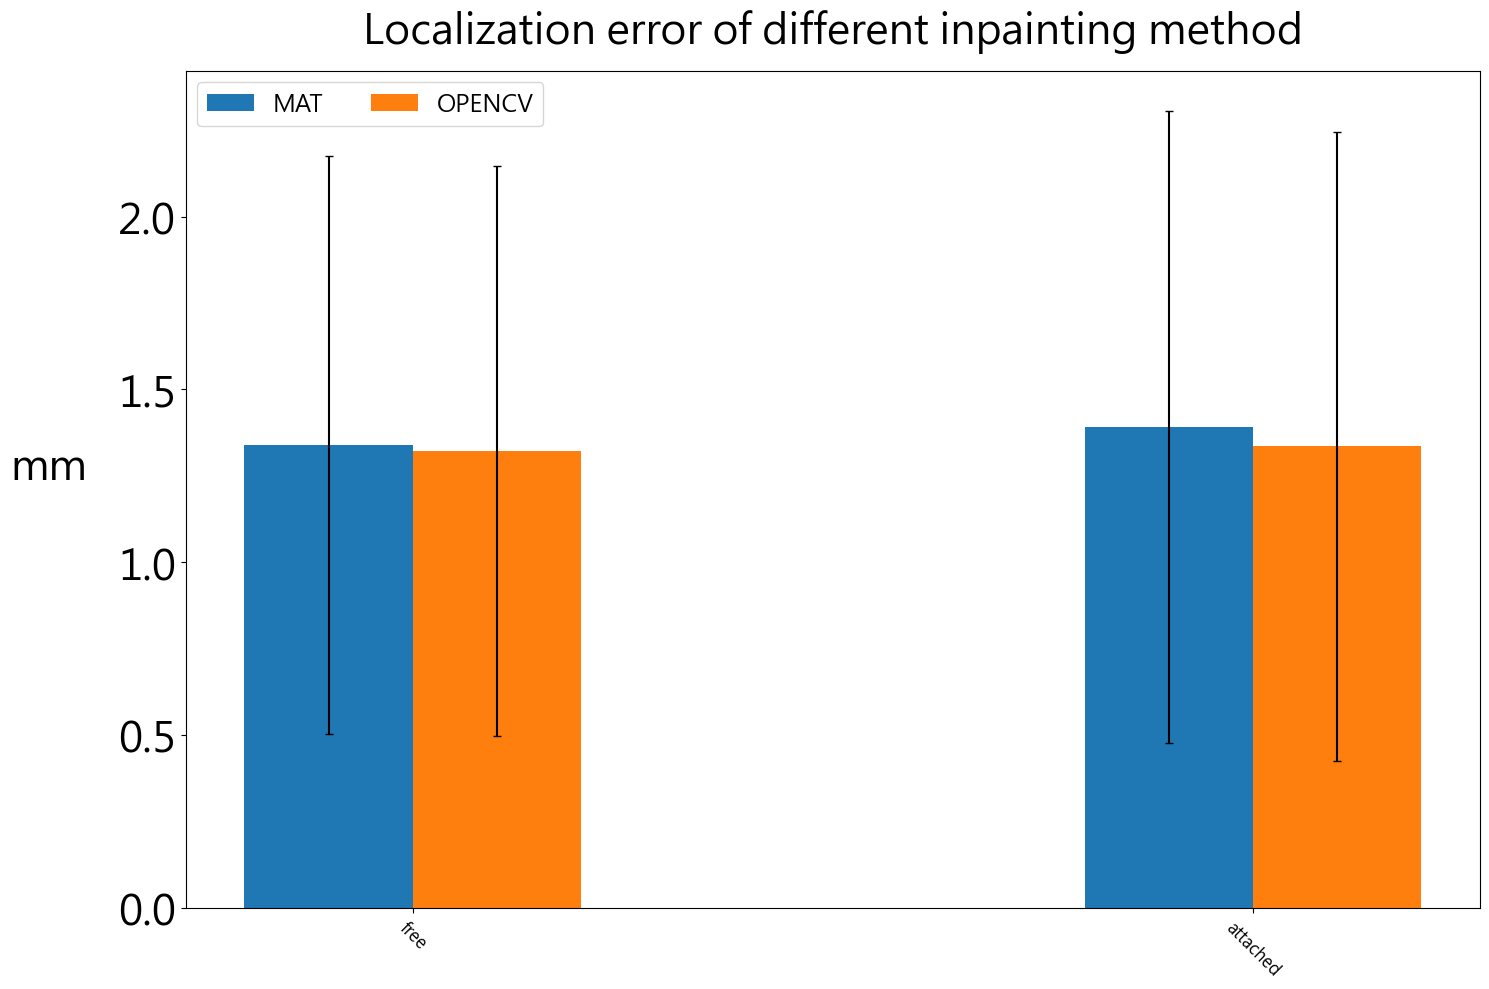

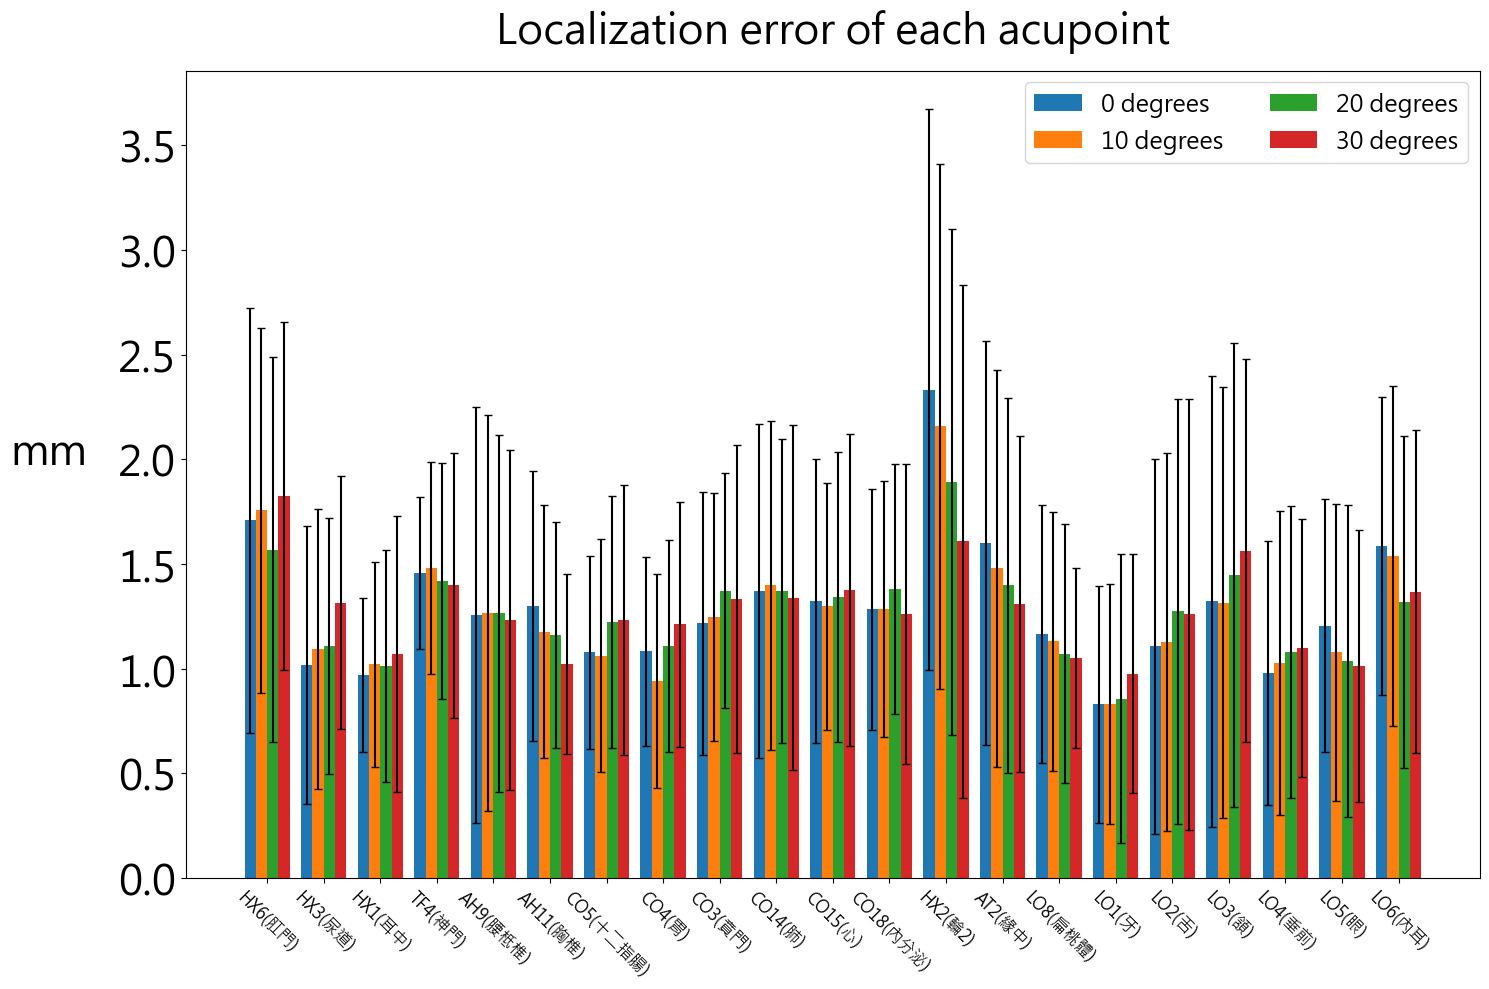

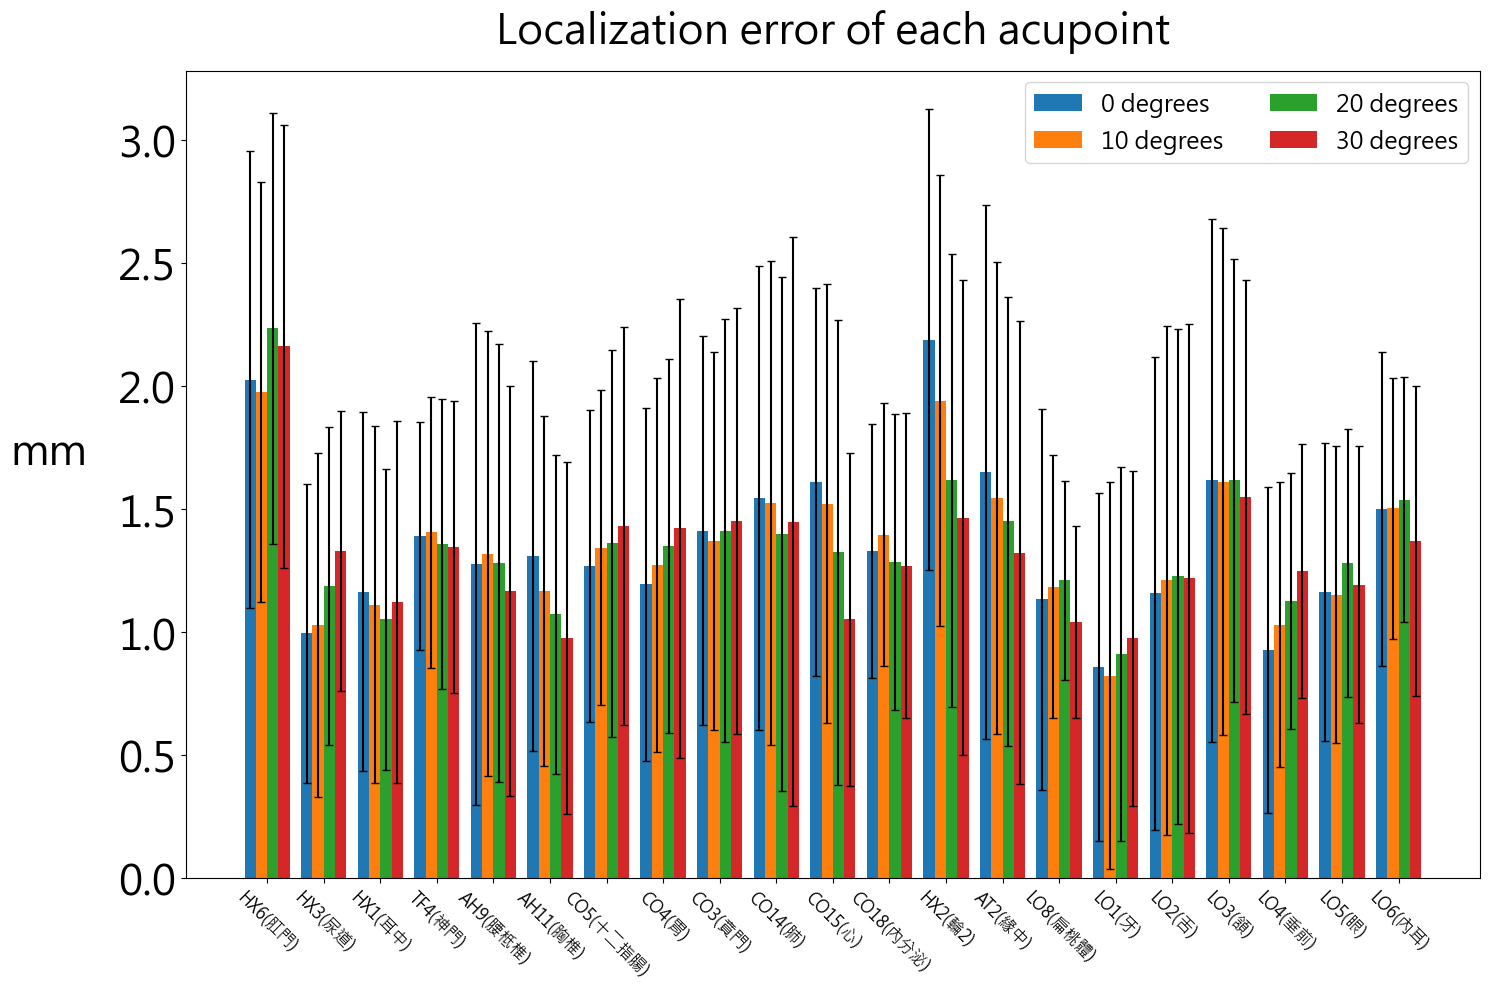

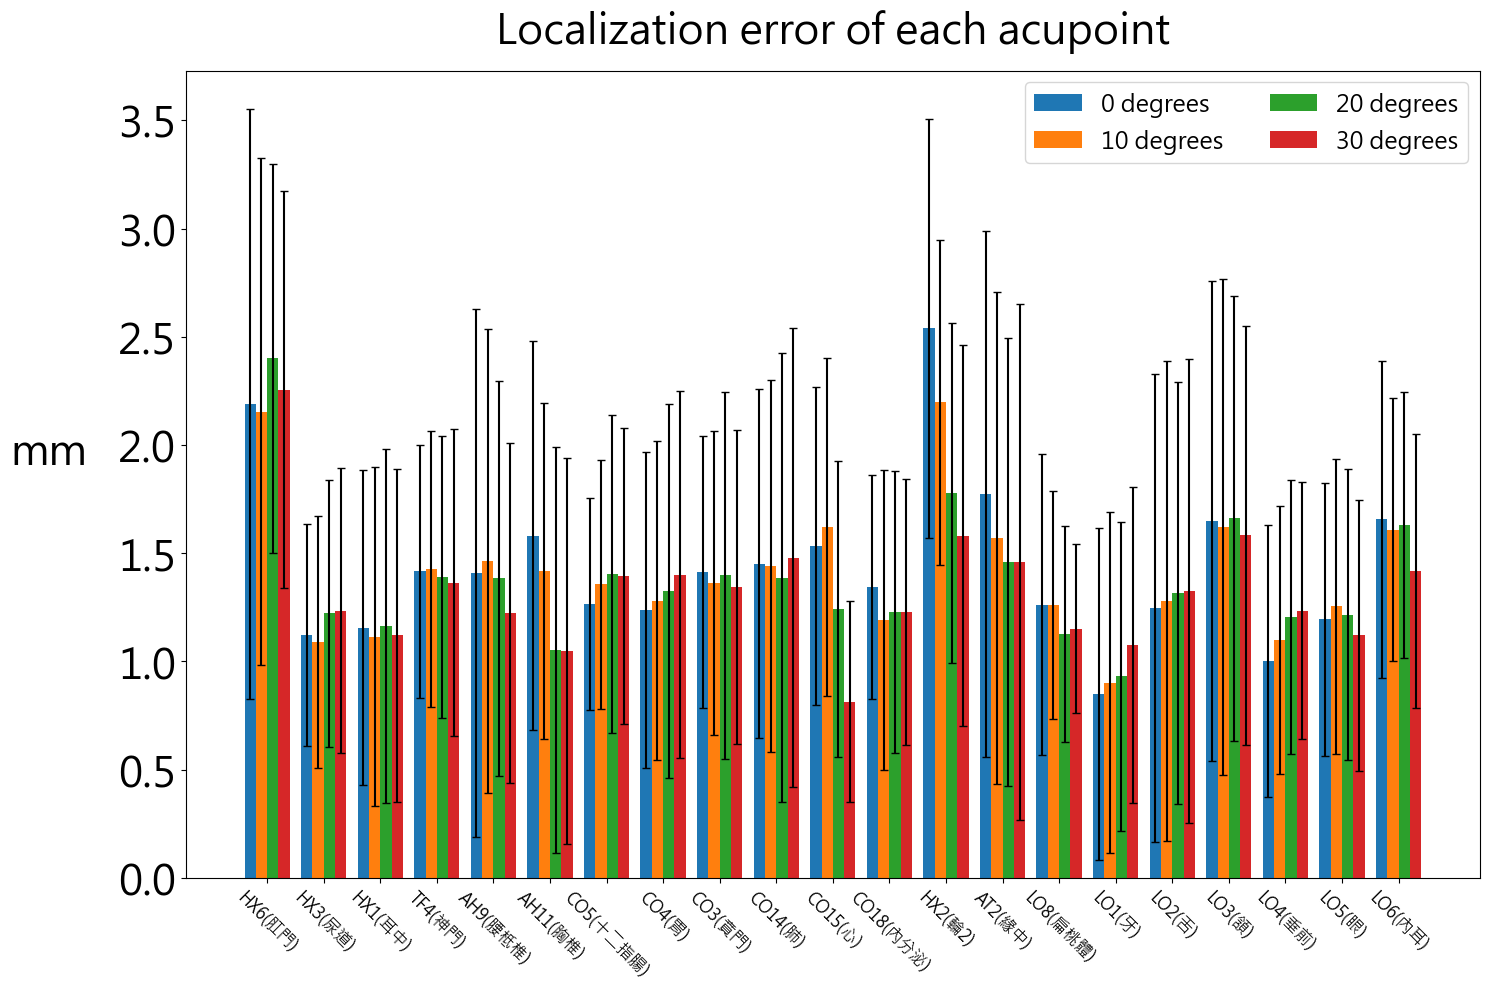

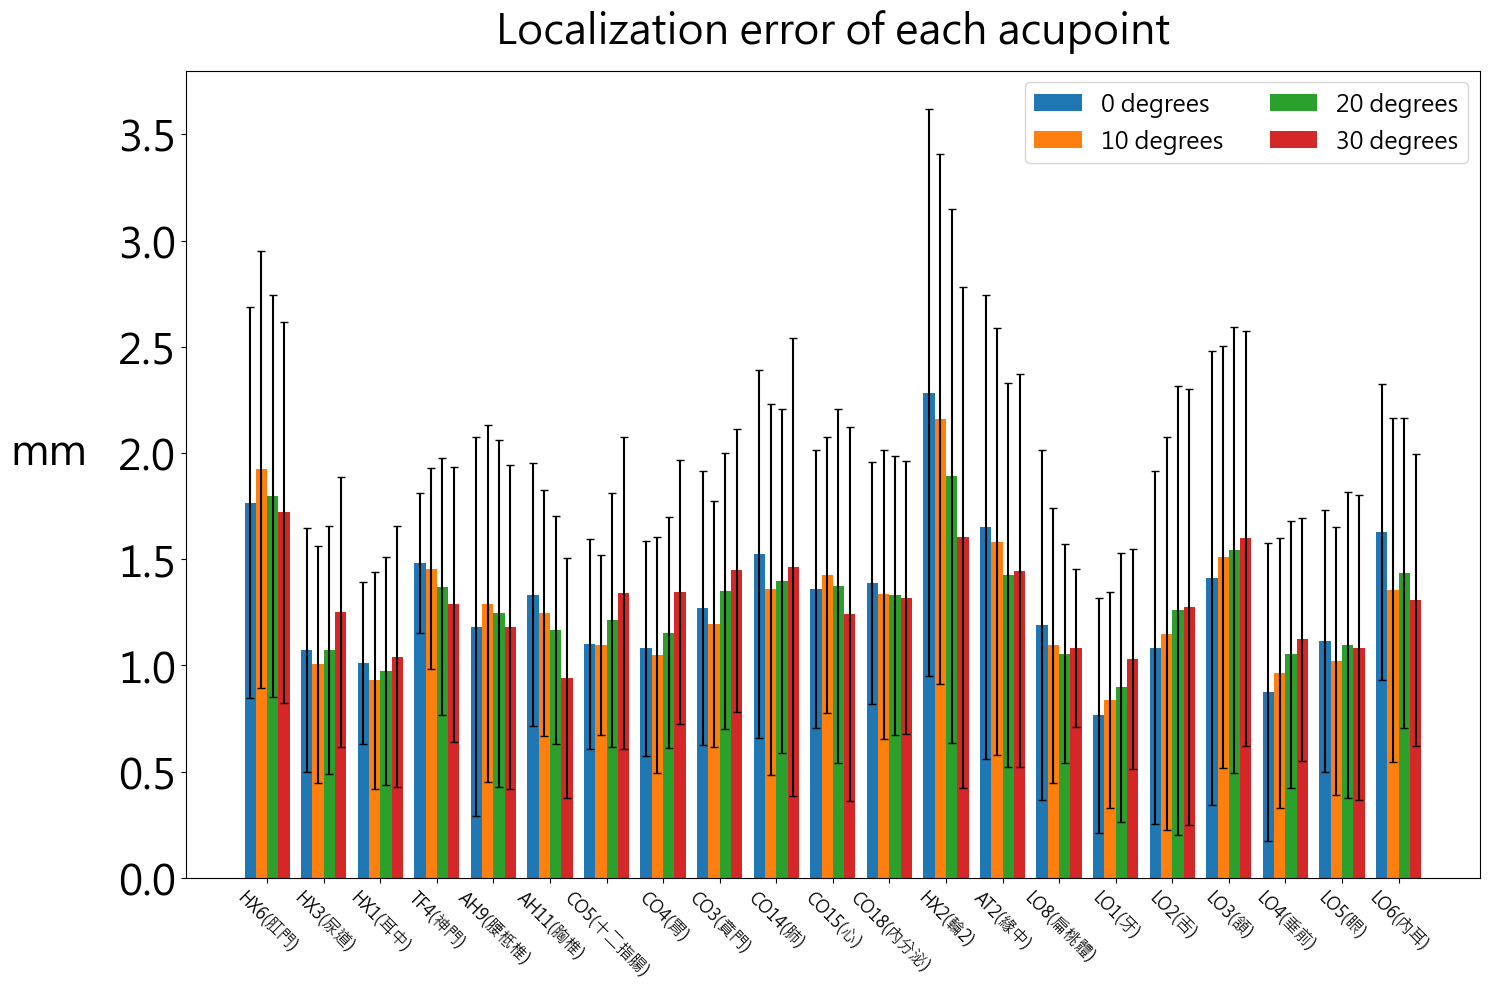

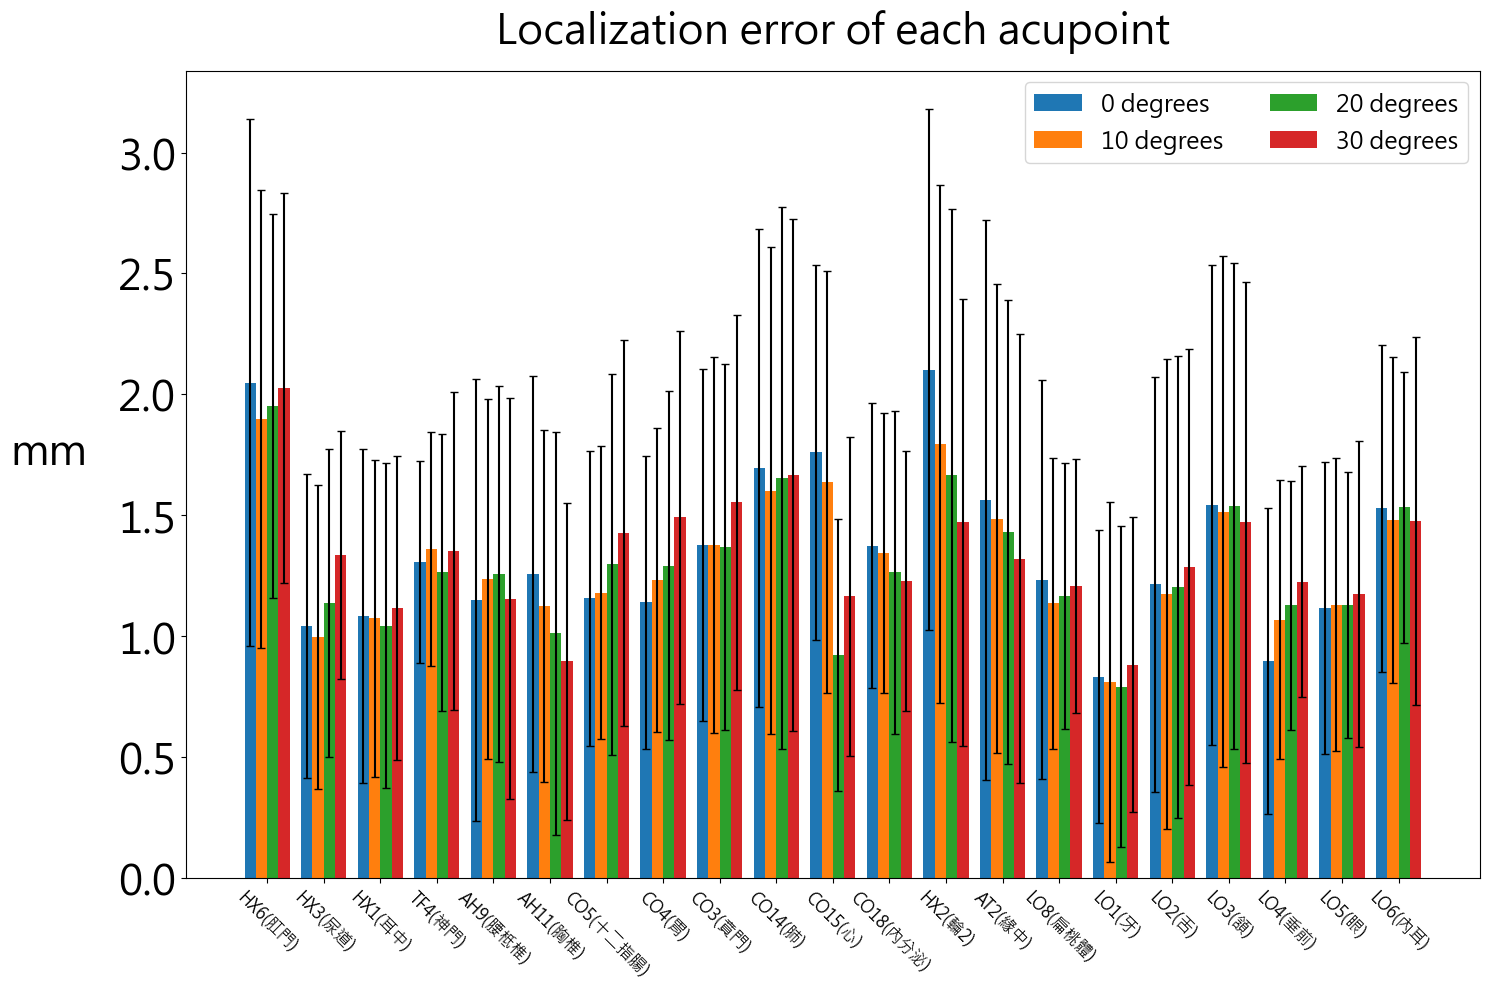

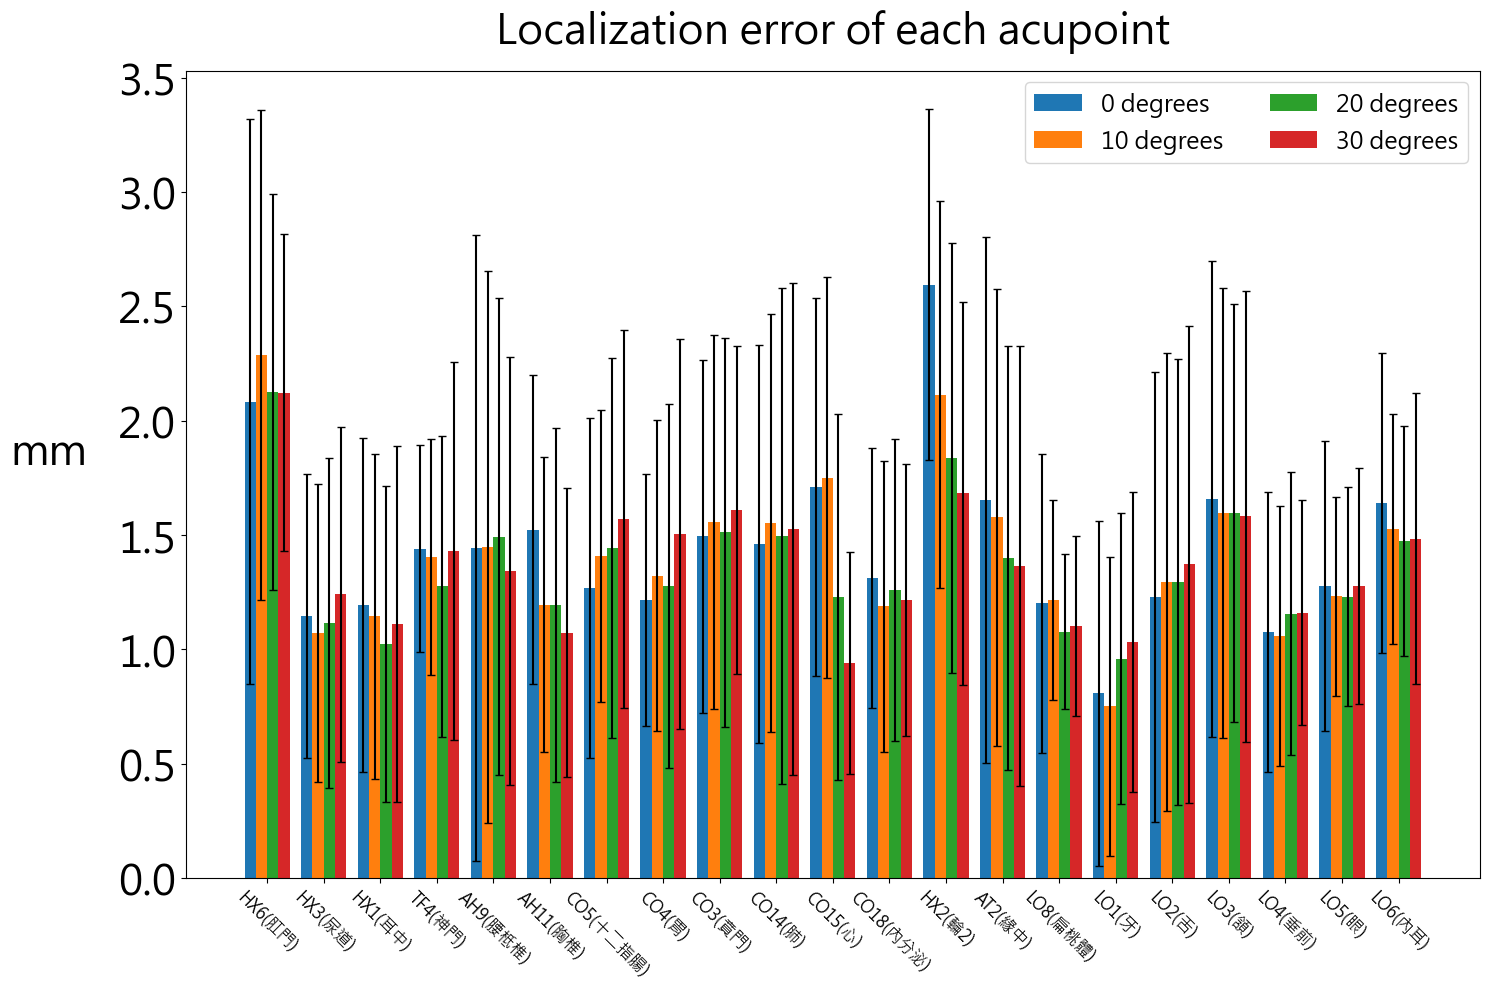

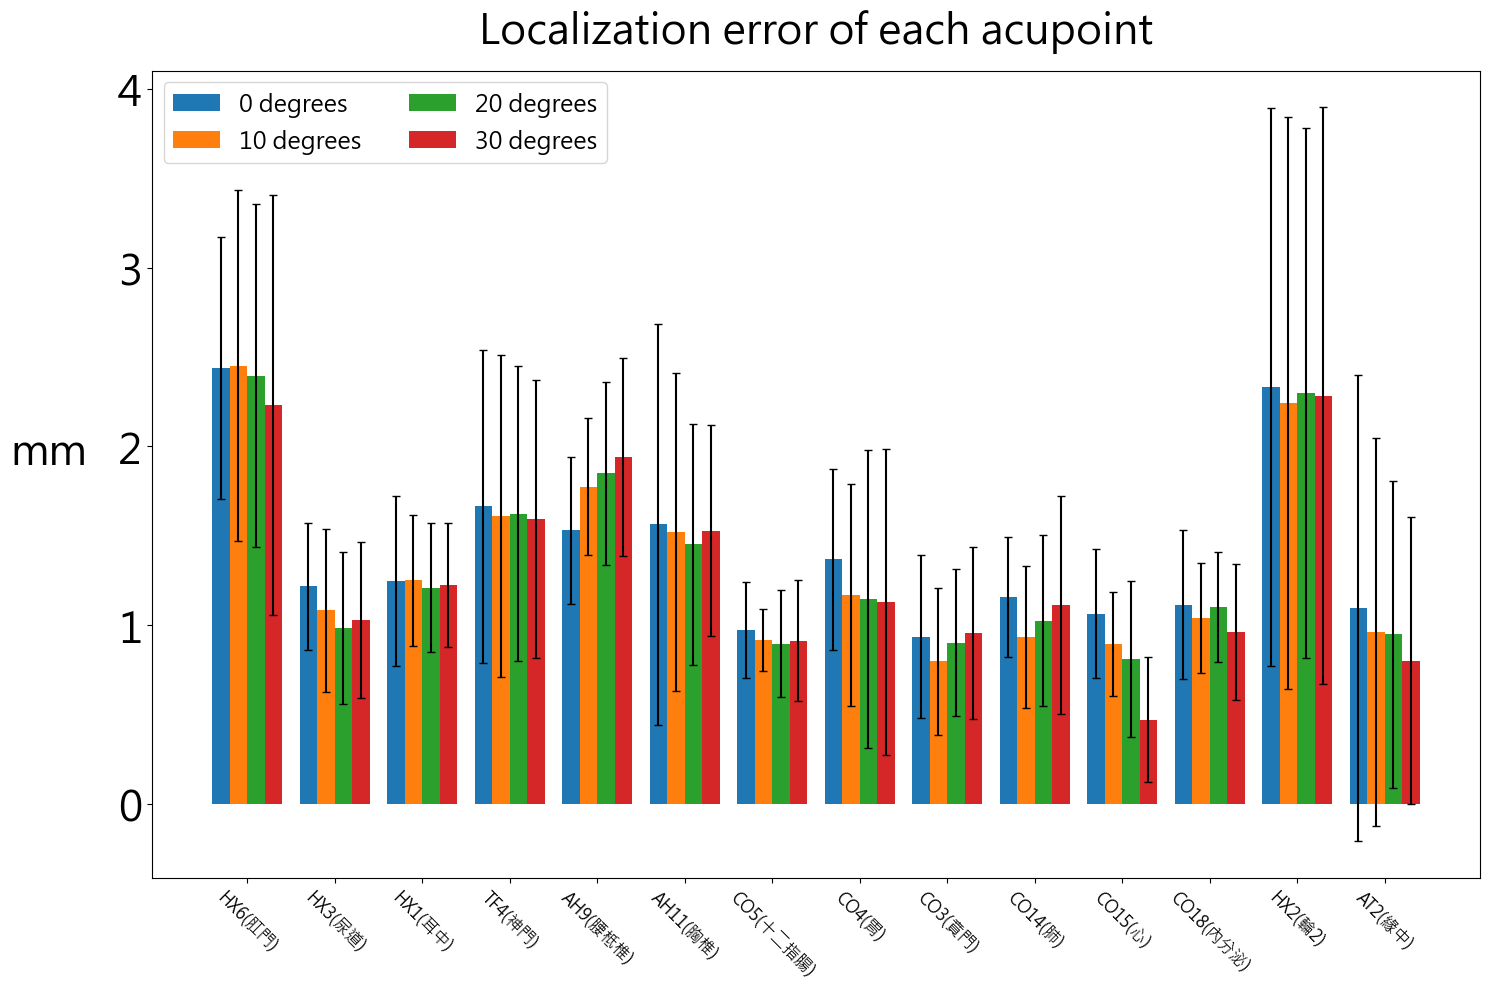

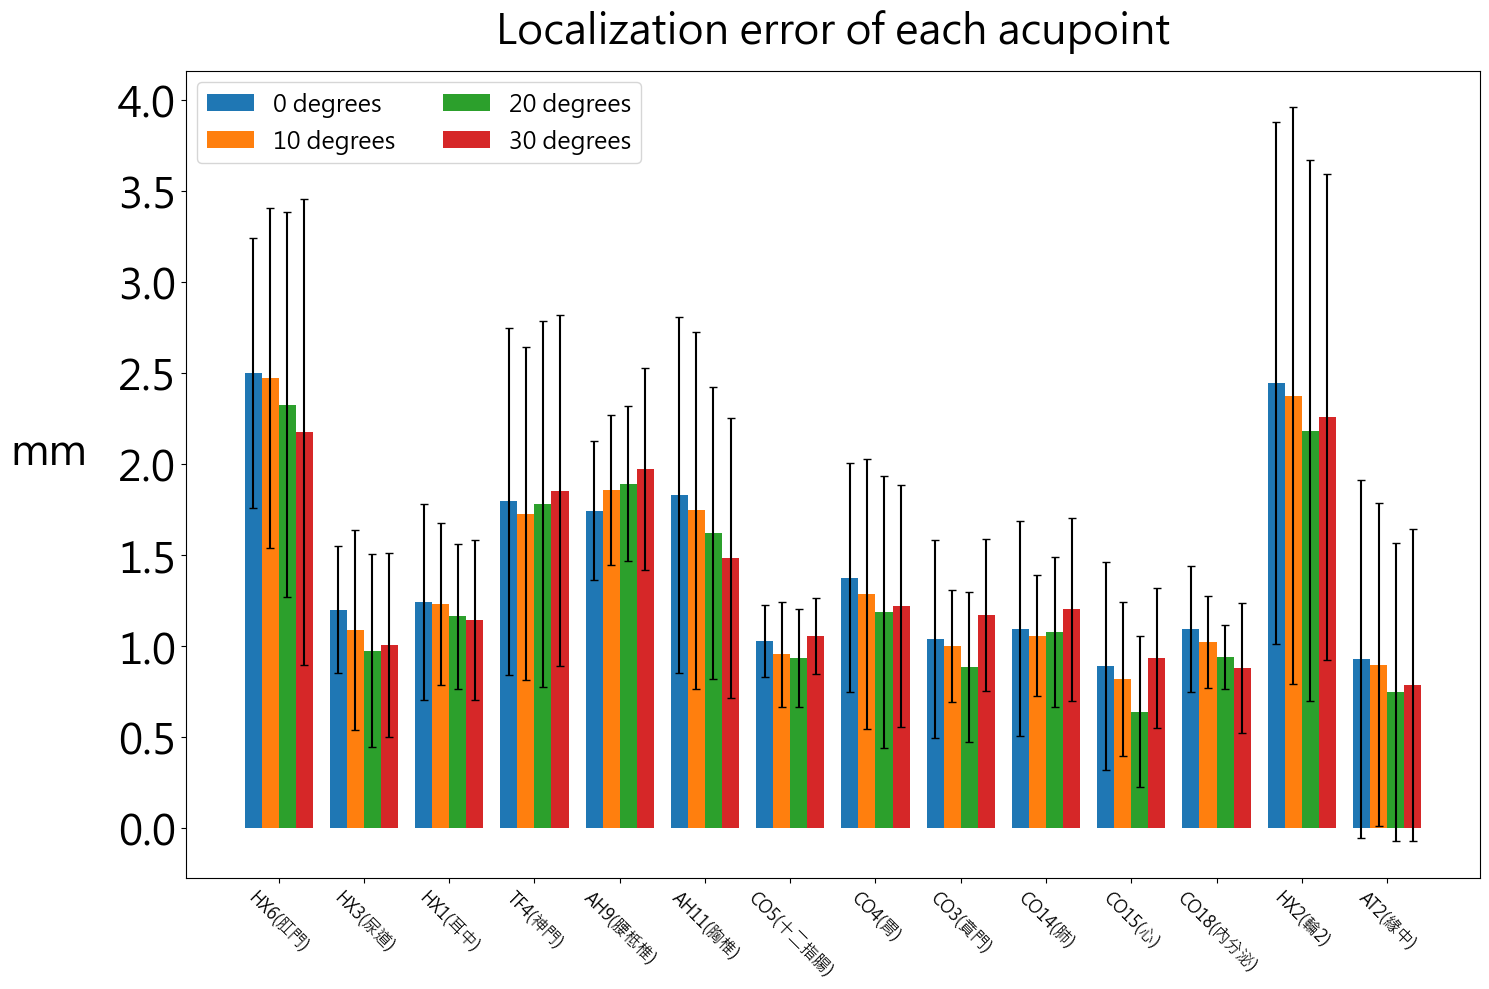

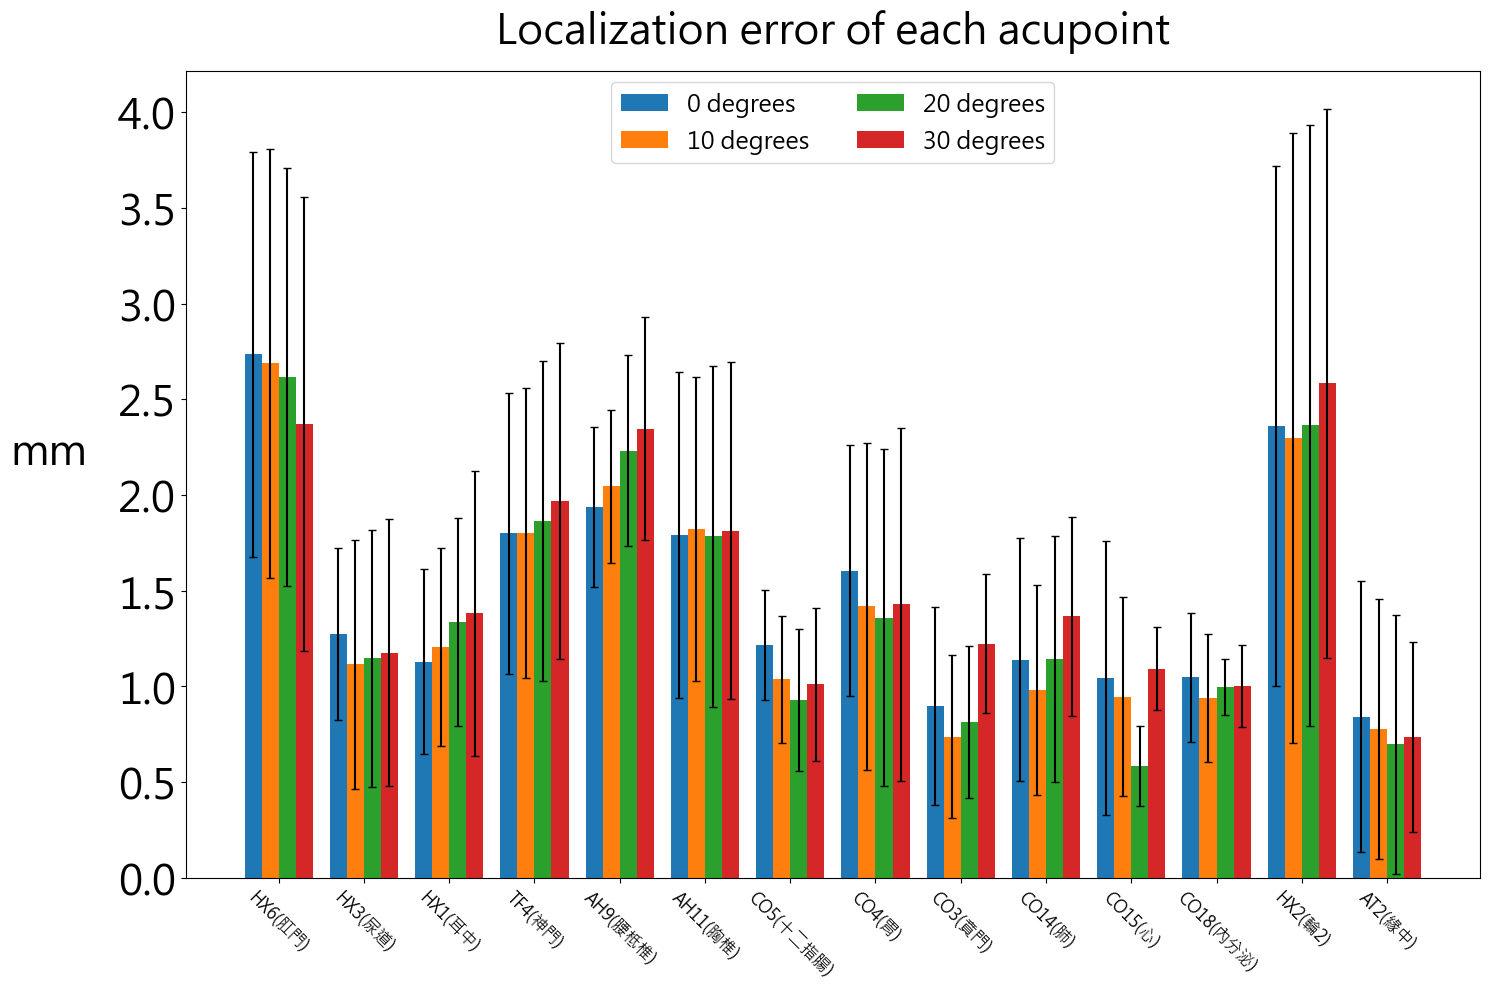

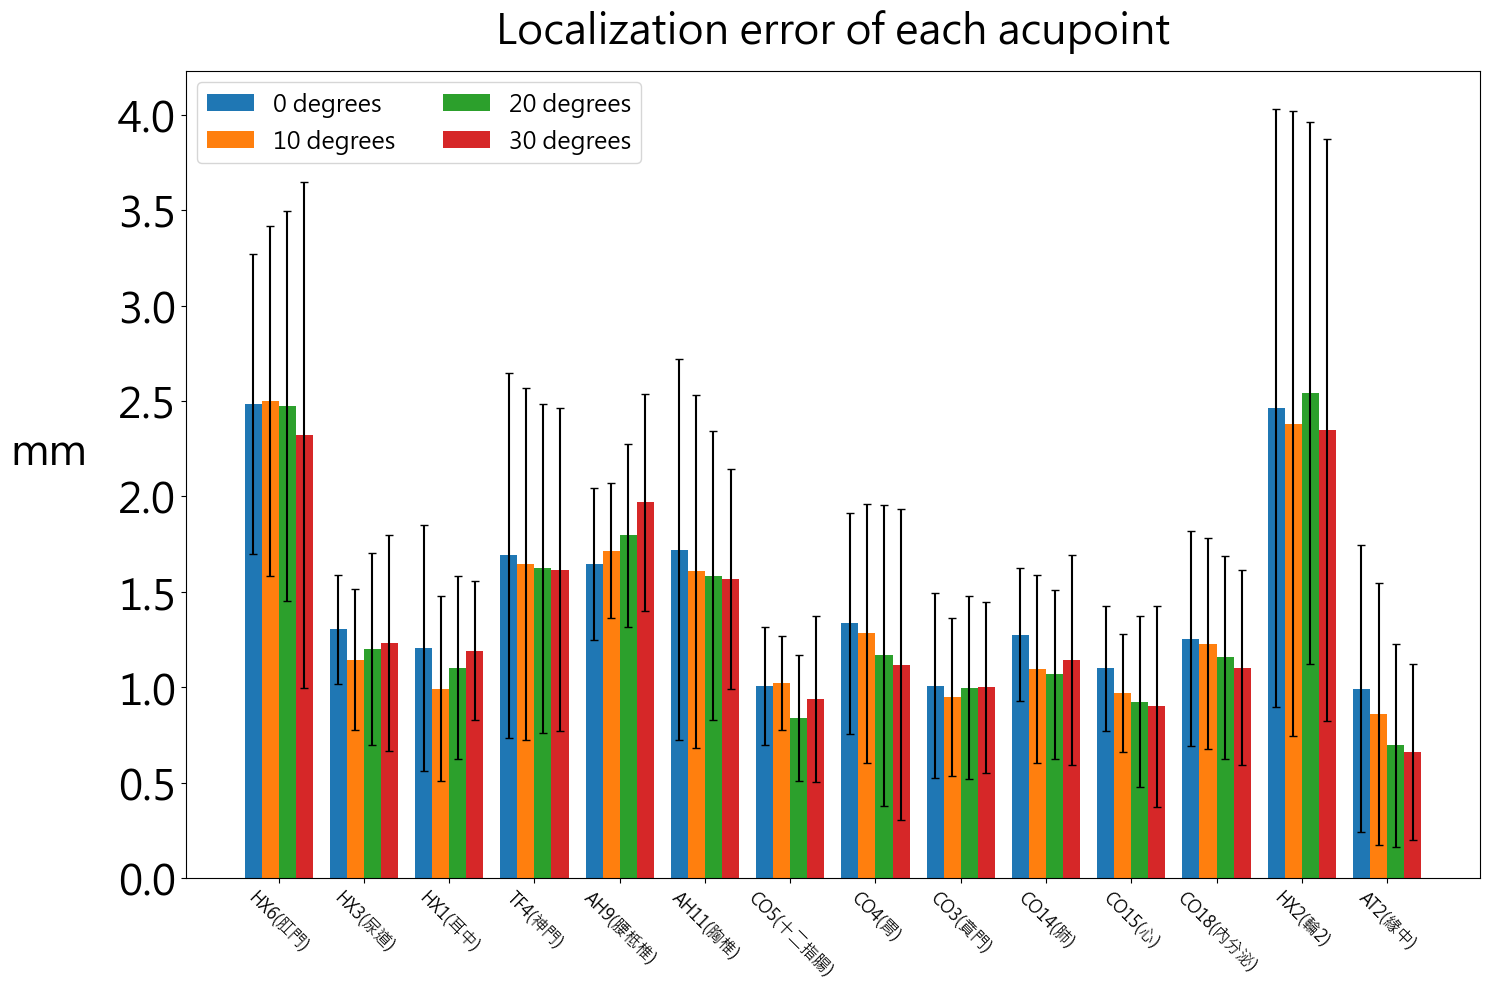

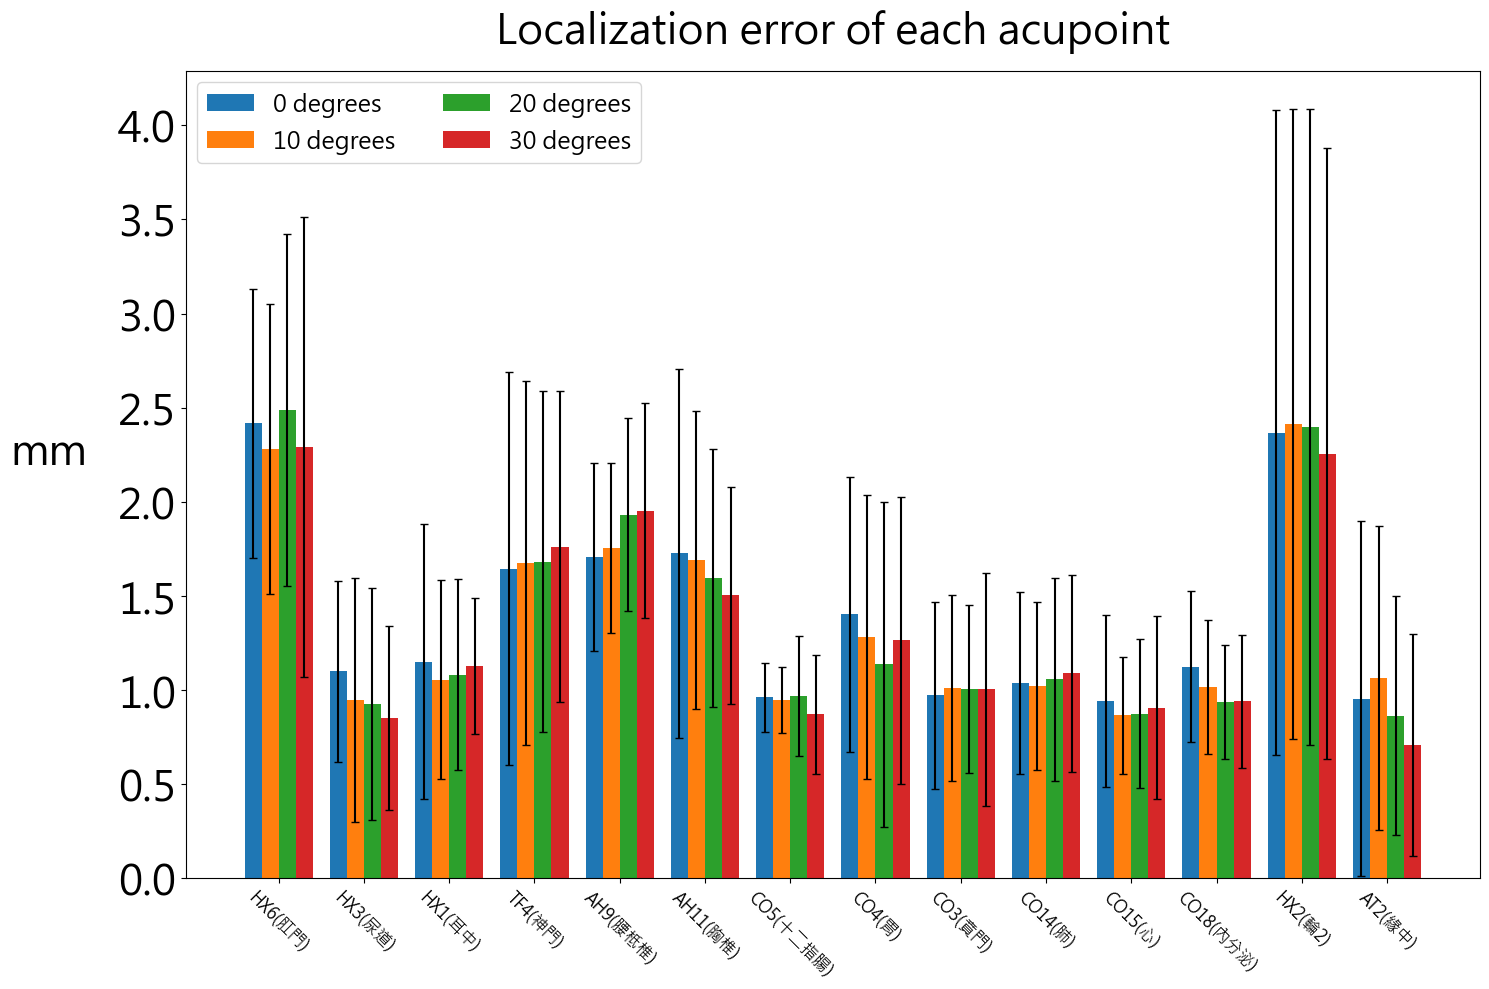

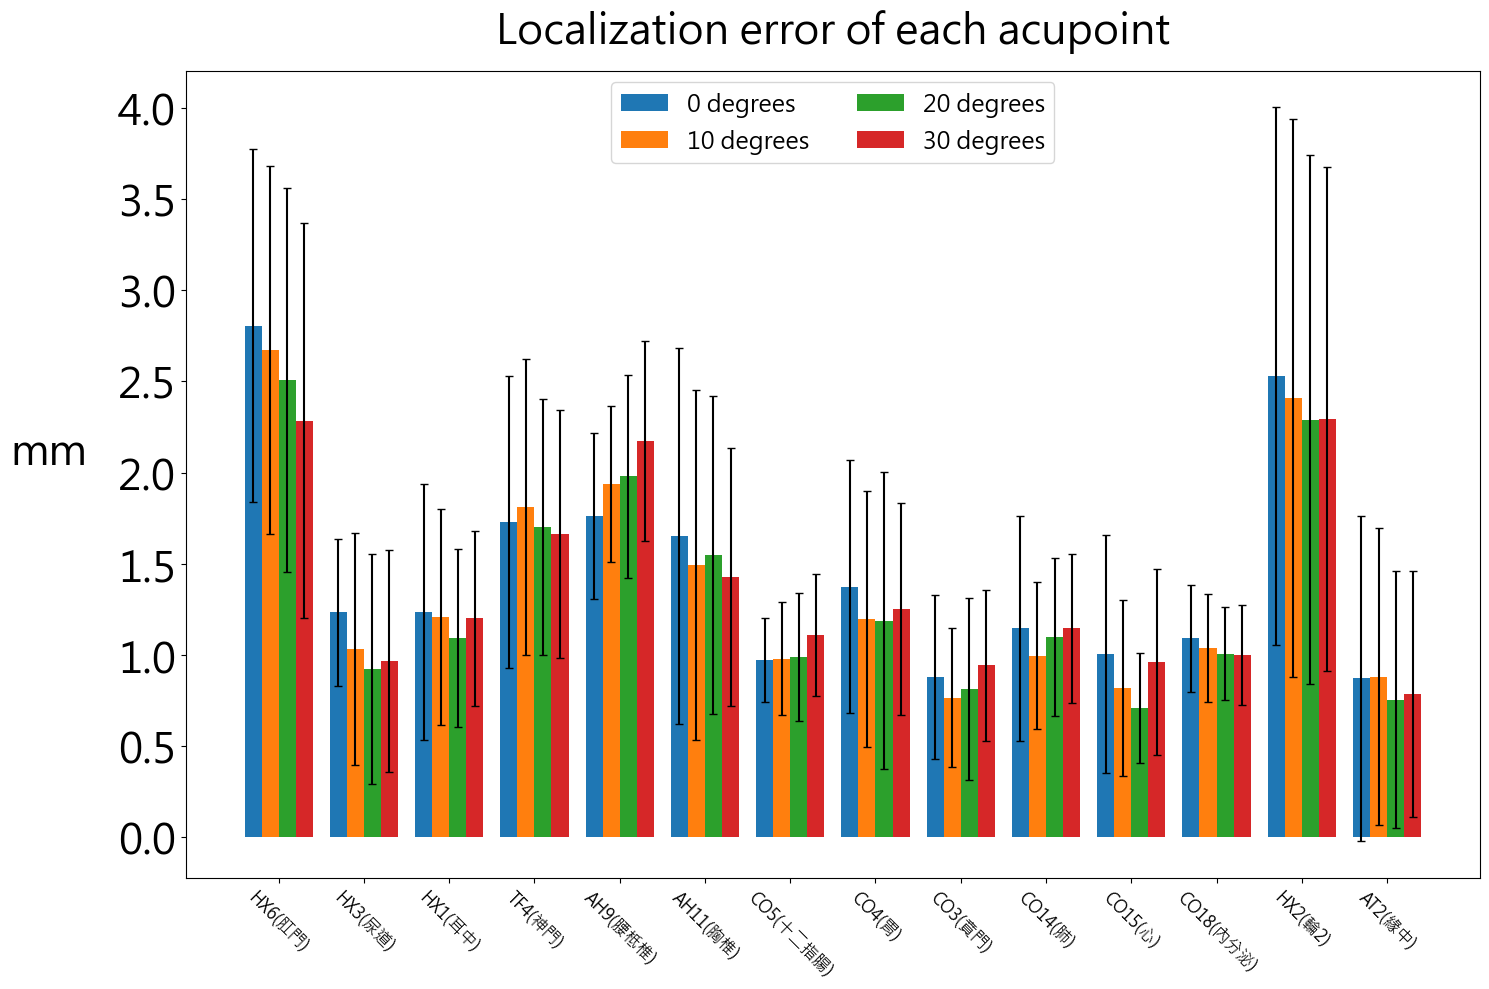

In [11]:
C = localization_error_Draw(A)
D = localization_error_Draw(B)
C.draw_total_bars("Localization error of different inpainting method",[C.all_err(),D.all_err()], ["MAT", "OPENCV"])
C.draw_each_acu_bars("Localization error of each acupoint",C.all_err())

In [116]:
acupoints_name = ["HX6(肛門)", "HX3(尿道)", "HX1(耳中)", "TF4(神門)", "AH9(腰柢椎)", "AH11(胸椎)", "CO5(十二指腸)", "CO4(胃)", "CO3(賁門)", "CO14(肺)", "CO15(心)", "CO18(內分泌)", "HX2(輪2)", "AT2(緣中)", "LO8(扁桃體)", "LO1(牙)" , "LO2(舌)", "LO3(頷)", "LO4(垂前)", "LO5(眼)", "LO6(內耳)"]
ear_types = ["free","attached"]

for ear_type in ear_types:
    if ear_type == "free":
        acupoints_num = 21
    else:
        acupoints_num = 14
    names = os.listdir(os.path.join(traditional_inpainting, ear_type, "result"))
    for deg in degrees:
        angles_mean = []
        angles_std = []
        for i in range(0, 4):

            sum_eight_people = []

            for name in names:
                error_file = glob.glob(os.path.join(traditional_inpainting, ear_type, "result", name, "error",deg,"*.csv"))[0]
                error_df = pd.read_csv(error_file, index_col = 0)

                interval = len(error_df) / 3
                temp = list(range(len(error_df)))
                index = [temp[0], temp[int(interval)], temp[int(interval*2)], temp[-1]]

                sum_eight_people.append(error_df.iloc[index[i],:].to_numpy())

            sum_eight_people = np.array(sum_eight_people)

            angles_mean.append(np.nanmean(sum_eight_people, axis=)*10)
            angles_std.append(np.nanstd(sum_eight_people, axis=0)*10)
        plt.figure(figsize=(15,10))

        for l in range(0 ,len(angles_mean)):

            plt.bar(np.arange(acupoints_num) + l*0.2, angles_mean[l], yerr=angles_std[l], align='center', label = '{index} degrees'.format(index = 0 + 10*l), ecolor='black', capsize=3, width=0.2)


        plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

        font_path = r'C:\Windows\Fonts\msjhl.ttc'
        font = FontProperties(fname=font_path, size=12)
        plt.xticks(np.arange(acupoints_num) + 0.3, acupoints_name[:acupoints_num], fontsize=12, rotation=-45, ha='center')


        plt.yticks(fontsize=30)
        plt.title('Localization error of different acupoints', fontsize = 30, pad = 20)

        plt.legend(fontsize=17)

        plt.tight_layout()

        if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
            os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))

        plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))
        plt.show()
        
    
    
        
        
                
        
        
        
        

SyntaxError: invalid syntax (559935867.py, line 29)

In [3]:
class localization_error_Draw():
    def __init__(self, le_0):
        self.le_0 = le_0
    def read_csv_to_np(self, fpath1):
        df_np = pd.read_csv(fpath1, index_col = 0).to_numpy()
        return df_np
    def angle_err(self):
        result = {}
        for ear_type in self.le_0.ear_types:
            result[ear_type] = []
            names = os.listdir(os.path.join("..", self.le_0.src, ear_type, "result"))
            for name in names:
                deg_err = []
                for deg in self.le_0.degrees:
                    angles_err = []
                    error_np = self.read_csv_to_np(os.path.join("..", self.le_0.src, ear_type, "result", name, "error", deg, "error.csv"))
                    interval = len(error_np) / 3
                    index = [0, int(interval), int(interval*2), len(error_np)-1]
                    for i in index:
                        angles_err.append(error_np[i])

                    deg_err.append(angles_err)

                result[ear_type].append(deg_err)             #shape = (subjects, degrees, angles, acupoints)           
            result[ear_type] = np.array(result[ear_type])
        return result
    def total_err(self):
        result = {}
        for ear_type in self.le_0.ear_types:
            result[ear_type] = []
            names = os.listdir(os.path.join("..", self.le_0.src, ear_type, "result"))
            for name in names:
                deg_err = []
                for deg in self.le_0.degrees:
                    error_np = self.read_csv_to_np(os.path.join("..", self.le_0.src, ear_type, "result", name, "error", deg, "error.csv"))
                    result[ear_type].append(error_np[0])   
            result[ear_type] = np.array(result[ear_type])
            print(result[ear_type].shape)
        return result
    def draw_each_acu_bars(self, title, all_err_0):
        for ear_type in self.le_0.ear_types:
            x = np.transpose(all_err_0[ear_type]*10, (1, 2, 3, 0))
            means = np.nanmean(x, axis = 3)
            stds = np.nanstd(x, axis = 3)
            for i in range(0, len(x)):
                plt.figure(figsize=(15,10))
                for j in range(0 ,len(x[0])):
                    
                    plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)


                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(x.shape[2]) + 0.3, self.le_0.acupoints_name[:x.shape[2]], fontsize=12, rotation=-45, ha='center')


                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17)

                plt.tight_layout()

#                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))
                
                plt.show()

    
        
        
        
    def draw_each_subject_bars(self, title, all_err_0):
        for ear_type in self.le_0.ear_types:
            x = np.transpose(all_err_0[ear_type]*10, (1, 2, 0, 3))
            means = np.nanmean(x, axis = 3)
            stds = np.nanstd(x, axis = 3)
            for i in range(0, len(x)):
                plt.figure(figsize=(15,10))
                for j in range(0 ,len(x[0])):
                    
                    plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)


                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(x.shape[2]) + 0.3, ["Subject"+str(x) for x in list(range(0 , x.shape[2]))], fontsize=12, rotation=-45, ha='center')


                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17)

                plt.tight_layout()

#                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))
                
                plt.show()
        
    def draw_total_bars(self, title, all_errs):
        plt.figure(figsize=(15,10))
        for i in range(0, len(all_errs)):
            means = []
            stds = []
            for ear_type in self.le_0.ear_types:
                means.append(np.nanmean(all_errs[i][ear_type], axis = (0,1))*10)
                stds.append(np.nanstd(all_errs[i][ear_type], axis = (0,1))*10)
                print(means)


            plt.bar(np.arange(len(self.le_0.ear_types)) + i*0.2, means, yerr=stds, align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)

        plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

        font_path = r'C:\Windows\Fonts\msjhl.ttc'
        font = FontProperties(fname=font_path, size=12)
        plt.xticks(np.arange(len(self.le_0.ear_types)) + 0.1, self.le_0.ear_types, fontsize=12, rotation=-45, ha='center')


        plt.yticks(fontsize=30)
        plt.title(title, fontsize = 30, pad = 20)

        plt.legend(fontsize=17, loc ="upper right")

        plt.tight_layout()

    #                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
    #                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
    #                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

        plt.show()

